<a href="https://colab.research.google.com/github/dvoils/neural-network-experiments/blob/main/ion_channels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Ion Channel Dynamics

## Introduction to Detailed Neuron Models

This section provides an in-depth look at how detailed ion channel dynamics affect the behavior of spiking neurons. Building upon the foundational Hodgkin-Huxley (HH) framework, we explore how additional ion channels—particularly A-type potassium currents—introduce new functional properties like spike delay and adaptation.

We base our analysis on Figures 2.8, 2.9, and 2.10 from the referenced neuroscience modeling text, which present activation and inactivation variables for various ionic currents. These graphical depictions form the basis for understanding the qualitative behavior of each current type.

## Canonical Hodgkin-Huxley Model

The Hodgkin-Huxley model describes the dynamics of a neuron's membrane potential $u(t)$ through a set of ordinary differential equations (ODEs). It includes three main ionic currents:

* **Sodium current (Na⁺):**
  $I_{\text{Na}} = \bar{g}_{\text{Na}} m^3 h (u - E_{\text{Na}})$

* **Potassium current (K⁺):**
  $I_{\text{K}} = \bar{g}_{\text{K}} n^4 (u - E_{\text{K}})$

* **Leak current:**
  $I_{\text{L}} = \bar{g}_{\text{L}} (u - E_{\text{L}})$

Each gating variable $x \in \{m, h, n\}$ evolves as:

$\frac{dx}{dt} = \frac{x_\infty(u) - x}{\tau_x(u)}$

These equations define the voltage-dependent steady-state value $x_\infty(u)$ and the time constant $\tau_x(u)$, capturing the rate of channel activation or inactivation.

We also included the explicitly defined **persistent sodium current**:

$I_{\text{NaP}} = \bar{g}_{\text{NaP}} m (u - E_{\text{Na}})$

This current is notable for its lack of inactivation and its role in promoting sustained depolarization.

## Characterizing Ion Channel Behavior

The activation ($m_\infty$) and inactivation ($h_\infty$) properties of various ion channels can be described in terms of their voltage-dependent steady-state values and time constants ($\tau_m$, $\tau_h$). These functions determine how quickly and under what conditions ion channels open or close in response to changes in membrane potential. The qualitative behaviors of these channels can be compared based on their characteristic activation thresholds and kinetic timescales.

| Channel | $\tau_m$ (ms) | $\tau_h$ (ms) | Functional Role                            |
| ------- | ------------- | ------------- | ------------------------------------------ |
| I\_NaP  | \~2           | N/A           | Persistent excitation, promotes bursting   |
| I\_Na   | \~1           | \~10          | Fast spike initiation                      |
| I\_T    | \~5           | \~50          | Low-threshold activation, burst triggering |
| I\_A    | \~5           | \~10          | Delays firing, spike timing regulation     |
| I\_K2   | \~20          | \~1000        | Spike-frequency adaptation                 |

## The Functional Impact of A-type Potassium Currents ($I_A$)

The effect of the A-type potassium current on spike timing can be observed in scenarios where a constant depolarizing current is applied, yet the neuron does not fire immediately. Instead, there is a significant delay—on the order of 100 milliseconds—before the first spike occurs. This delay arises because the A-type current initially activates and counteracts the depolarizing input, and only after its inactivation variable decays sufficiently does the membrane potential rise to threshold, allowing the neuron to fire.

This delay is explained by the slow inactivation of the A-type current:

* The activation variable $m_A$ quickly turns on the outward current.
* The inactivation variable $h_A$ decays slowly over time.
* While $h_A$ is high, the outward potassium current counteracts depolarization.
* Once $h_A$ becomes sufficiently small, the membrane potential is free to rise and reach spike threshold.

## Simulating Long-Latency Firing with an A-type Current**

To demonstrate the concept illustrated in Figure 2.10, we implemented a simplified simulation using only:

* A leak current $I_L$
* An A-type potassium current $I_A$
* A step current input $I_{\text{ext}}$

### Equations Used:

* A-type current:
  $I_A = \bar{g}_A \cdot m_\infty(u) \cdot h_A \cdot (u - E_K)$

* Membrane potential dynamics:
  $\frac{du}{dt} = \frac{-I_A - I_L + I_{\text{ext}}}{C_m}$

* Inactivation variable dynamics:
  $\frac{dh_A}{dt} = \frac{h_\infty(u) - h_A}{\tau_h(u)}$

The simulation shows:

* No immediate response to the stimulus.
* A delayed spike corresponding to the time it takes for $h_A$ to decay.

This verified the book’s assertion that A-type currents can control spike timing.


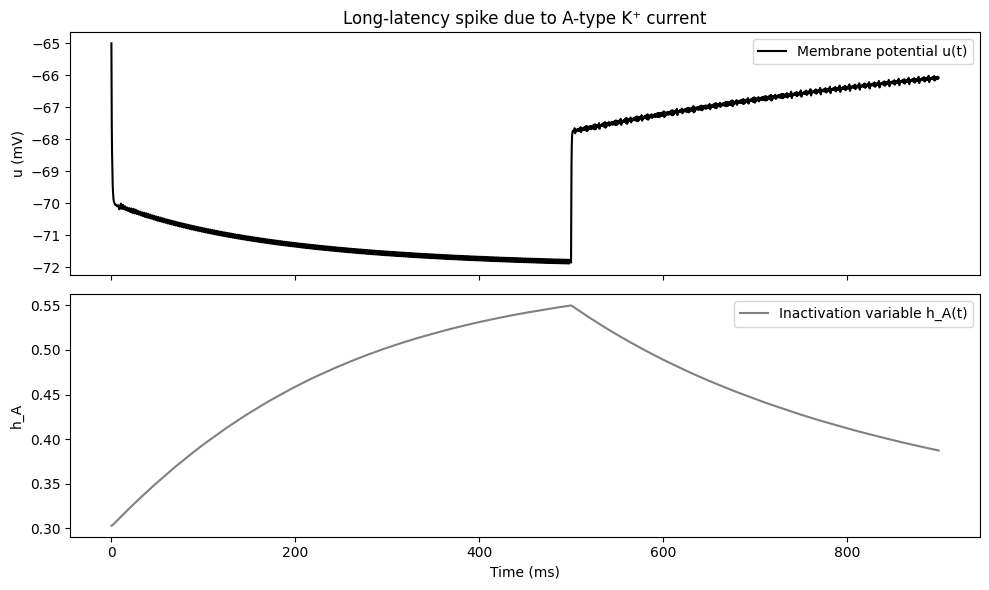

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Simulation parameters
T = 900.0  # total simulation time (ms)
dt = 0.1
t_eval = np.arange(0, T, dt)

# External current
def I_ext(t):
    return 10.0 if t >= 500 else 0.0  # step current at t = 500 ms

# HH model parameters (simplified)
C_m = 1.0  # membrane capacitance (uF/cm^2)
g_L = 0.3  # leak conductance
E_L = -54.387  # leak reversal potential
E_K = -77.0
g_A = 10.0  # A-type K+ conductance
E_A = E_K  # same reversal potential as K+

# Gating kinetics for A-type current
def m_inf_A(u):  # fast activation
    return 1 / (1 + np.exp(-(u + 60) / 8))

def h_inf_A(u):  # slow inactivation
    return 1 / (1 + np.exp((u + 70) / 6))

def tau_h_A(u):  # slow inactivation time constant (ms)
    return 150 + 100 * np.exp(-((u + 55) / 15)**2)

# ODE system
def neuron_with_IA(t, y):
    u, h_A = y
    m_A = m_inf_A(u)
    I_A = g_A * m_A * h_A * (u - E_A)
    I_leak = g_L * (u - E_L)
    du_dt = ( - I_A - I_leak + I_ext(t) ) / C_m
    dh_A_dt = (h_inf_A(u) - h_A) / tau_h_A(u)
    return [du_dt, dh_A_dt]

# Initial conditions: resting membrane potential and fully available h_A
u0 = -65.0  # mV
h_A0 = h_inf_A(u0)
y0 = [u0, h_A0]

# Solve ODEs
sol = solve_ivp(neuron_with_IA, [0, T], y0, t_eval=t_eval, method='RK45')

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(sol.t, sol.y[0], label='Membrane potential u(t)', color='black')
axs[0].set_ylabel('u (mV)')
axs[0].set_title('Long-latency spike due to A-type K⁺ current')
axs[0].legend()

axs[1].plot(sol.t, sol.y[1], label='Inactivation variable h_A(t)', color='gray')
axs[1].set_ylabel('h_A')
axs[1].set_xlabel('Time (ms)')
axs[1].legend()

plt.tight_layout()
plt.show()
